# Název projektu
## 155UZPR - Katedra Geomatiky - Fsv ČVUT
### Tereza Černohousová - Matěj Klimeš
### ZS2024

In [2]:
import fiona
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
import folium
import matplotlib
import mapclassify
import zipfile
import os
from eodag import EODataAccessGateway
import numpy as np
import rasterio as rio

Stažení data250 pro stanovení oblasti zájmu

In [3]:
# Source URL
url = "https://openzu.cuzk.cz/opendata/Data250/epsg-5514/data250.zip"

# Cílový adresář
zip_filename = "data250.zip"

# Stažení jen pokud ZIP zatím nebyl stažen
if not os.path.exists(zip_filename):
    print(f"ZIP soubor {zip_filename} neexistuje, stahuji data...")
    urllib.request.urlretrieve(url, zip_filename)
    print(f"Soubor {zip_filename} byl úspěšně stažen.")
else:
    print(f"ZIP soubor {zip_filename} již existuje. Stažení přeskočeno.")

ZIP soubor data250.zip již existuje. Stažení přeskočeno.


Import vrstvi obcí ze staženého ZIPu

In [4]:
obce = gpd.read_file("data250.zip!/PolbndMunDA.shp")
obce.head()

,FCSUBTYPE,F_CODE,ICC,SHN0,SHN1,SHN2,SHN3,TAA,ICOB,NUTS3,ISN,NAMN,DESN,SHAPE_Leng,SHAPE_Area,geometry
0,1,FA001,CZ,CZ0000000000,CZ0100000000,UNK,CZ0100554782,1,554782,CZ010,4605,Praha,obec,157071.726075,4.963111e+08,"POLYGON ((-733582.756 -1034199.856, -733690.30..."
1,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201513482,1,513482,CZ020,4605,Vysoký Újezd,obec,13689.999181,4.064693e+06,"POLYGON ((-742125.829 -1072463.392, -742056.67..."
2,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529303,1,529303,CZ020,4605,Benešov,obec,54242.943513,4.682135e+07,"POLYGON ((-729711.586 -1073957.287, -729679.83..."
3,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529451,1,529451,CZ020,4605,Bystřice,obec,64917.905895,6.343932e+07,"POLYGON ((-730989.011 -1081012.603, -731007.23..."
4,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529478,1,529478,CZ020,4605,Čakov,obec,13297.559487,5.318608e+06,"POLYGON ((-716606.98 -1075299.75, -716493.11 -..."


Výběr geometrie pro zadanou oblast

In [5]:
obec_zajmu = "Katovice"
aoi = obce[obce["NAMN"] == obec_zajmu]["geometry"]

Zobrazení oblasti

<Axes: title={'center': 'Hranice obce: Katovice'}>

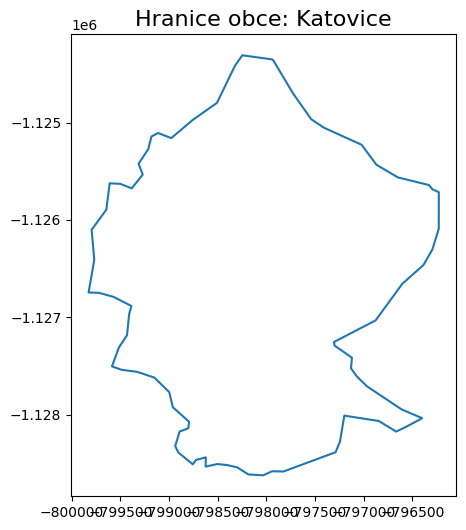

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f"Hranice obce: {obec_zajmu}", fontsize=16)
aoi.boundary.plot(ax=ax)

In [7]:
aoi_map = aoi.set_crs(epsg=5514)
aoi_map.boundary.explore()

## Prace se SENTINEL

In [8]:
dag = EODataAccessGateway()
product = "S2_MSI_L2A" # definition of product
dag.available_providers(product)

['astraea_eod',
 'cop_dataspace',
 'creodias',
 'onda',
 'planetary_computer',
 'sara']

In [9]:
extent = tuple(aoi_map.to_crs(4326).total_bounds)
extent
dag.set_preferred_provider("cop_dataspace")
results = dag.search(
    productType="S2_MSI_L2A",
    start="2024-10-01", 
    end="2024-10-23",
    geom=tuple(extent),
    count=True
)
print(results.number_matched)

8


In [10]:
# Nalezene produkty

results_cc = results.filter_property(operator="le", cloudCover=5)
results_cc

SearchResult([EOProduct(id=S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806, provider=cop_dataspace)])

In [11]:
username = "cernote2@cvut.cz"
password = "Copernicus*2024UZPR"

dag.update_providers_config(f"""
cop_dataspace:
    download:
        extract: False
        outputs_prefix: /tmp/sentinel
        delete_archive: False
    auth:
        credentials:
            username: {username}
            password: {password}
""")

quicklooks/S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0.00B [00:00, ?B/s]


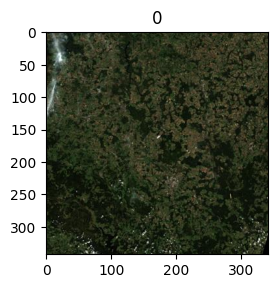

In [12]:
# prohlednuti sceny pred stazenim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(results_cc, start=1):
    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()

    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()

In [13]:
# stahovani dat
from pathlib import Path
data_path = dag.download(results_cc[0])



0.00B [00:00, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0.00B [00:00, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0file [00:00, ?file/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 100%|███████████████████| 1/1 [00:00<00:00, 133.78file/s]


In [14]:
print(data_path, Path(data_path).exists())

C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip True


In [15]:
def SpectralIndexes(si, data_path, clip_polygon, clip_polygon_name):
    # Import necessary libraries
    import rasterio.mask as mask
    from rasterio.enums import Resampling
    from rasterio.io import MemoryFile

    # Initialization of subdatasets (reading the Sentinel-2 data)
    with rio.open(data_path) as ds:
        sd = ds.subdatasets  # List of available subdatasets (bands) in the Sentinel-2 data

    # Print information about the Sentinel-2 bands
    print('Sentinel-2 data information:')
    for i in range(0, 2):  # Loop through the first 2 subdatasets (bands)
        print('Subdataset:', i)
        with rio.open(sd[i]) as subds:
            sd_crs = subds.crs.to_epsg()  # Extract the CRS (Coordinate Reference System) of the data
            for b in subds.indexes:  # Iterate through each band in the subdataset
                print(b, subds.tags(b)['BANDNAME'])  # Print the band number and its name

    # Transform the clip polygon to match the CRS of the Sentinel-2 data
    clip_sen = clip_polygon.to_crs(epsg=sd_crs)

    # Crop the Sentinel-2 datasets using the clipped polygon for the first subdataset (band 1)
    with rio.open(sd[0]) as src:
        crop_sen_clip0, out_transform0 = mask.mask(src, clip_sen, crop=True)  # Clip the first dataset
        crop_sen_clip0 = crop_sen_clip0.astype(float)  # Convert the data to float for calculation
        crop_sen_clip0[crop_sen_clip0 == 0] = np.nan  # Set nodata values to NaN

    # Crop the Sentinel-2 datasets for the second subdataset (band 2)
    with rio.open(sd[1]) as src:
        crop_sen_clip1, out_transform1 = mask.mask(src, clip_sen, crop=True)  # Clip the second dataset
        crop_sen_clip1 = crop_sen_clip1.astype(float)  # Convert the data to float for calculation
        crop_sen_clip1[crop_sen_clip1 == 0] = np.nan  # Set nodata values to NaN

    # Extract specific bands for calculation from the cropped datasets
    R = crop_sen_clip0[0]  # Red band (B4)
    G = crop_sen_clip0[1]  # Green band (B3)
    B = crop_sen_clip0[2]  # Blue band (B2)
    NIR = crop_sen_clip0[3]  # Near-Infrared band (B8)

    SWIR1 = crop_sen_clip1[4]  # Short-Wave Infrared 1 band (B11)
    SWIR2 = crop_sen_clip1[5]  # Short-Wave Infrared 2 band (B12)

    # Resample SWIR1 to match the resolution of the NIR band
    target_height, target_width = NIR.shape  # Get the target resolution (height and width) from the NIR band
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=SWIR1.shape[0],
            width=SWIR1.shape[1],
            count=1,
            dtype=SWIR1.dtype,
            transform=out_transform1
        ) as dataset:
            dataset.write(SWIR1, 1)  # Write SWIR1 band to the virtual file

            # Resample SWIR1 to match the resolution of NIR using bilinear interpolation
            swir1_resampled = dataset.read(
                1,
                out_shape=(target_height, target_width),
                resampling=Resampling.bilinear
            )

    # Function to resample other bands (e.g., SWIR1, SWIR2) to match NIR resolution
    def resample_band(band, out_transform, target_height, target_width):
        with MemoryFile() as memfile:
            with memfile.open(
                driver="GTiff",
                height=band.shape[0],
                width=band.shape[1],
                count=1,
                dtype=band.dtype,
                transform=out_transform,
            ) as dataset:
                dataset.write(band, 1)  # Write the band to the virtual file

                # Resample the band to match the target resolution of NIR
                resampled_band = dataset.read(
                    1,
                    out_shape=(target_height, target_width),
                    resampling=Resampling.bilinear,
                )
        return resampled_band

    # Resample SWIR1 and SWIR2 bands to match the resolution of NIR
    target_height, target_width = NIR.shape
    SWIR1 = resample_band(SWIR1, out_transform1, target_height, target_width)
    SWIR2 = resample_band(SWIR2, out_transform1, target_height, target_width)
    
    # INDEX CALCULATION based on the selected spectral index (si)
    if si == 'NDVI':  # NDVI calculation (Normalized Difference Vegetation Index)
        raster = (NIR - R) / (NIR + R)
    elif si == 'NDWI':  # NDWI calculation (Normalized Difference Water Index)
        raster = (G - NIR) / (G + NIR)
    elif si == 'NDMI':  # NDMI calculation (Normalized Difference Moisture Index)
        raster = (NIR - SWIR1) / (NIR + SWIR1)
    elif si == 'AWEISH':  # AWEISH calculation (Automated Water Extraction Index for Shadow)
        raster = B + 2.5 * G - 1.5 * (NIR + SWIR1) - 0.25 * SWIR2

    # Display the result of the spectral index calculation as a heatmap
    plt.imshow(raster)  # Show the calculated spectral index as an image
    plt.suptitle(si)  # Title of the plot: spectral index name
    plt.title(clip_polygon_name)  # Subtitle: name of the clipped polygon
    plt.colorbar()  # Display a colorbar
    return raster  # Return the calculated raster (spectral index)


C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Sentinel-2 data information:
Subdataset: 0
1 B4
2 B3
3 B2
4 B8
5 AOT
6 WVP
Subdataset: 1
1 B5
2 B6
3 B7
4 B8A
5 B11
6 B12
7 AOT
8 CLD
9 SCL
10 SNW
11 WVP


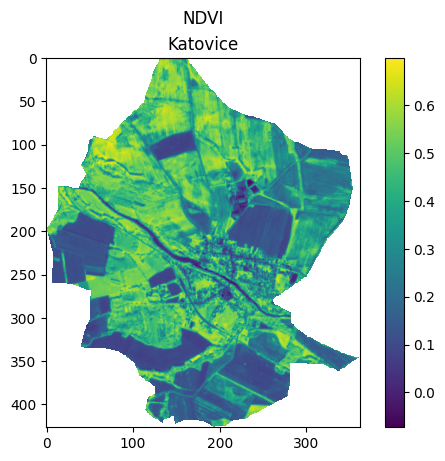

In [16]:
NDVI = SpectralIndexes('NDVI', data_path, aoi, obec_zajmu)

In [26]:
from sklearn.cluster import KMeans 


In [32]:

# Cesta k multispektrálnímu rastru Sentinel-2

# Otevření rasterového souboru

with rio.open(data_path) as ds:
        sd = ds.subdatasets  # List of available subdatasets (bands) in the Sentinel-2 data
with rio.open(sd[0]) as subds:
    bands = []
    for i in range(1, subds.count + 1):  # Načtení všech pásem
        band = subds.read(i)
        bands.append(band)
    # Převod seznamu na numpy pole (tvar: [pásma, výška, šířka])
    data = np.stack(bands)

# Převod dat na 2D matici (tvar: [počet pixelů, počet pásem])
data_2d = data.reshape(data.shape[0], -1).T




[array([[1255, 1204, 1120, ..., 1662, 1668, 1683],
       [1110, 1092, 1107, ..., 1688, 1668, 1681],
       [1112, 1136, 1160, ..., 1708, 1673, 1683],
       ...,
       [1043, 1073, 1220, ...,    0,    0,    0],
       [1089, 1080, 1235, ...,    0,    0,    0],
       [1094, 1098, 1374, ...,    0,    0,    0]], dtype=uint16), array([[1433, 1290, 1171, ..., 1758, 1810, 1774],
       [1207, 1129, 1154, ..., 1732, 1768, 1785],
       [1165, 1227, 1236, ..., 1759, 1756, 1773],
       ...,
       [1075, 1154, 1184, ...,    0,    0,    0],
       [1158, 1176, 1269, ...,    0,    0,    0],
       [1160, 1164, 1436, ...,    0,    0,    0]], dtype=uint16), array([[1252, 1192, 1141, ..., 1441, 1460, 1467],
       [1178, 1116, 1109, ..., 1452, 1466, 1478],
       [1147, 1142, 1184, ..., 1443, 1466, 1466],
       ...,
       [1036, 1069, 1128, ...,    0,    0,    0],
       [1057, 1076, 1144, ...,    0,    0,    0],
       [1046, 1055, 1282, ...,    0,    0,    0]], dtype=uint16), array([[3779, 2

In [35]:
# Počet klastrů
n_clusters = 4  # Např. voda, vegetace, město, zemědělská půda

# Inicializace K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Trénink modelu na datech
kmeans.fit(data_2d)

# Získání výsledných tříd (tvar: [počet pixelů])
labels = kmeans.labels_

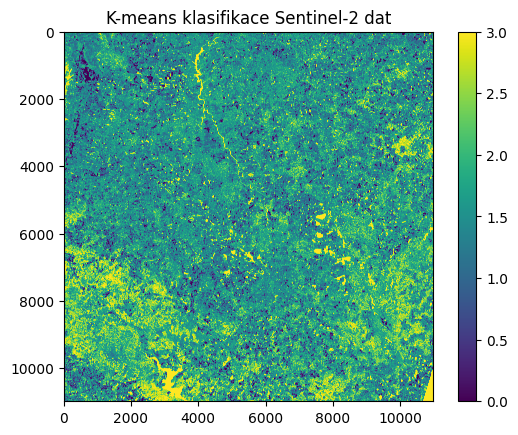

In [47]:
# Převod výsledků zpět na 2D obraz (tvar: [výška, šířka])
labels_2d = labels.reshape(data.shape[1], data.shape[2])

# Zobrazení klasifikovaného obrazu
plt.imshow(labels_2d)  # Tab10 je barevná mapa
plt.colorbar()
plt.title("K-means klasifikace Sentinel-2 dat")
plt.show()


In [54]:

with rio.open(sd[0]) as subds1:
    meta = subds1.meta

meta.update({
    "driver": 'GTiff',
    "dtype": "int8",
    "height": labels_2d.shape[0],
    "width": labels_2d.shape[1],
    # "transform": labels_2d.crs(), # dodelat funkci na clip a pak clipnout i tohle
    "nodata": 0
})
np.nan_to_num(labels_2d, copy=False)

with rio.open('KMeans_Classif.tif', 'w', **meta) as dst:
   dst.write_band(1, labels_2d.astype(rio.int8))

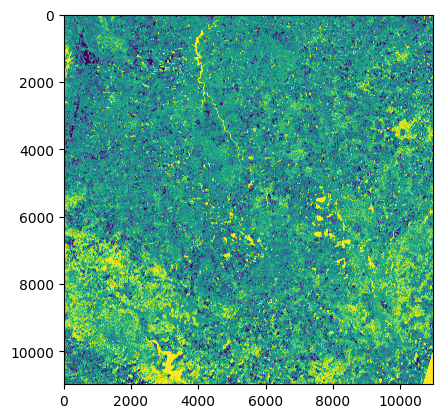

In [59]:
classifTif = 'KMeans_Classif.tif'
with rio.open(classifTif) as neco:
    classified = neco.read(1)

plt.imshow(classified)